CaseStudy Selection: IMDb
-------------------
Problem Statement: Ratings Analysis on Movies
-----------------
The goal of this analysis is to evaluate and derive insights from the provided movie dataset, focusing on ratings and their associated factors. The dataset contains information on various movies including their Title, Year, Duration, Rating, Vote Count, Metascore, Content rating, and Description.

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2024-01-01,2024-11-20&user_rating=10,6"

In [2]:
headers={ "User-Agent": "microsoft Edge/112.0.1722.39", 

        "Accept-Language" : "en-US,en;q=0.5",

        "Accept-Encoding" : "gzip, deflate, br",

        "Connection": "keep-alive",

        }
page=requests.get(url, headers=headers)
page

<Response [200]>

In [3]:
pagecontent = page.text
pagecontent

'<!DOCTYPE html><html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><script>if(typeof uet === \'function\'){ uet(\'bb\', \'LoadTitle\', {wb: 1}); }</script><script>window.addEventListener(\'load\', (event) => {\n        if (typeof window.csa !== \'undefined\' && typeof window.csa === \'function\') {\n            var csaLatencyPlugin = window.csa(\'Content\', {\n                element: {\n                    slotId: \'LoadTitle\',\n                    type: \'service-call\'\n                }\n            });\n            csaLatencyPlugin(\'mark\', \'clickToBodyBegin\', 1732181797893);\n        }\n    })</script><title>Advanced search</title><meta name="description" content="" data-id="main"/><meta property="og:url" content="https://www.imdb.com/search/"/><meta property="og:site_name" content="IMDb"/><meta property="og:title" content="Advanced sea

In [4]:
soup = BeautifulSoup(pagecontent)
soup

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><script>window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa('Content', {
                element: {
                    slotId: 'LoadTitle',
                    type: 'service-call'
                }
            });
            csaLatencyPlugin('mark', 'clickToBodyBegin', 1732181797893);
        }
    })</script><title>Advanced search</title><meta content="" data-id="main" name="description"/><meta content="https://www.imdb.com/search/" property="og:url"/><meta content="IMDb" property="og:site_name"/><meta content="Advanced search" property="og:title"/><meta content="" property=

In [4]:
pip install selenium webdriver-manager beautifulsoup4 requests

   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
    --------------------------------------- 0.2/9.7 MB 4.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/9.7 MB 6.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/9.7 MB 6.1 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/9.7 MB 7.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/9.7 MB 7.1 MB/s eta 0:00:02
   ------- -------------------------------- 1.9/9.7 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.3/9.7 MB 7.2 MB/s eta 0:00:02
   ----------- ---------------------------- 2.7/9.7 MB 7.5 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.7 MB 7.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.1/9.7 MB 6.9 MB/s eta 0:00:01
   ------------- -------------------------- 3.2/9.7 MB 6.4 MB/s eta 0:00:02
   ------------- -------------------------- 3.3/9.7 MB 5.9 MB/s eta 0:00:02
   ------------- --

In [36]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException

def scrape_data(url, max_titles=500):
    # Initialize the WebDriver
    driver = webdriver.Chrome()  # Adjust path to your WebDriver if needed
    driver.get(url)
    driver.maximize_window()

    data = []
    try:
        # Wait for the first batch of movie cards to load
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".sc-54004b59-3.eOhSkH.dli-parent"))
        )
    except TimeoutException:
        print("Timeout: Movie cards not found.")
        driver.quit()
        return []

    while len(data) < max_titles:
        try:
            # Find all movie cards
            cards = driver.find_elements(By.CSS_SELECTOR, ".sc-54004b59-3.eOhSkH.dli-parent")
            for card in cards:
                title = year = duration = rating = vote_count = content_rating = metascore = None

                # Extract Title
                try:
                    title_element = card.find_element(By.CSS_SELECTOR, "h3.ipc-title__text")
                    title = title_element.text.strip().lstrip("0123456789. ")
                except Exception:
                    pass

                # Extract Year
                try:
                    year = np.NaN
                    metadata_items = card.find_elements(By.CSS_SELECTOR, "span.sc-6ade9358-7.exckou.dli-title-metadata-item")
                    for item in metadata_items:
                        text = item.text.strip()
                        if text.isdigit() and len(text) == 4:
                            year = text
                            break
                        elif '–' in text and len(text.split('–')) == 2 and text.split('–')[0].isdigit():
                            year = text.split('–')[0].strip()
                            break
                except Exception:
                    pass

                # Extract Duration
                try:
                    for item in metadata_items:
                        if 'h' in item.text or 'm' in item.text:  # Check for duration format
                            duration = item.text.strip()
                            break
                except Exception:
                    pass

                # Extract Content Rating
                try:
                    valid_ratings = ["G", "PG", "PG-13", "R", "NC-17", "TV-Y", "TV-Y7", "TV-G", "TV-PG", "TV-14", "TV-MA", "15", "18", "U", "12A","Unrated"]  # Add observed ratings to the list

                    content_rating = np.NaN  # Default if no valid content rating is found
                    for item in metadata_items:
                        text = item.text.strip()
                        
                        # Check if the text matches a valid content rating
                        if text in valid_ratings:
                            content_rating = text
                            break  # Stop once a valid content rating is found
                        
                        # Skip irrelevant metadata
                        elif text.isdigit() or 'h' in text or 'm' in text:
                            continue  # These are likely year or duration values
                            
                except Exception:
                    pass

                # Extract Rating
                try:
                    rating_element = card.find_element(By.CSS_SELECTOR, ".ipc-rating-star--rating")
                    rating = rating_element.text.strip()
                except Exception:
                    pass

                # Extract Vote Count
                try:
                    vote_count_element = card.find_element(By.CSS_SELECTOR, ".ipc-rating-star--voteCount")
                    vote_count = vote_count_element.text.strip()

                    if vote_count.startswith("(") and vote_count.endswith(")"):
                        vote_count = vote_count[1:-1] 
                        
                except Exception:
                    pass

                # Extract Metascore
                try:
                    metascore_element = card.find_element(By.CSS_SELECTOR, ".sc-b0901df4-0.bXIOoL.metacritic-score-box")
                    if metascore_element:
                        metascore = metascore_element.text.strip()
                except Exception:
                    metascore = "N/A"  # Set default value if not found

                # Extract Description
                try:
                    desc_element = card.find_element(By.CSS_SELECTOR, ".ipc-html-content-inner-div")
                    if desc_element:
                        desc = desc_element.text.strip()
                except Exception:
                       desc = "N/A"  # Set default value if not found

                # Append data to list
                data.append({
                    "Title": title,
                    "Year": year,
                    "Duration": duration,
                    "Content Rating": content_rating,
                    "Rating": rating,
                    "Vote Count": vote_count,
                    "Metascore": metascore,
                    "Description": desc
                })

            # Check if the "Load More" button is available and click it
            try:
                load_more_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, ".ipc-see-more__button"))
                )
                driver.execute_script("arguments[0].scrollIntoView(true);", load_more_button)
                load_more_button.click()
                WebDriverWait(driver, 10).until(EC.staleness_of(load_more_button))
            except TimeoutException:
                print("No more titles to load.")
                break
            except ElementClickInterceptedException:
                print("Load More button not clickable. Retrying...")
                driver.execute_script("arguments[0].click();", load_more_button)
        except Exception as e:
            print(f"Error during scraping: {e}")
            break

    driver.quit()
    
    df = pd.DataFrame(data)
    return df

# Example usage
url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2024-01-01,2024-11-20&user_rating=10,6"  # Replace with the actual URL
scraped_data = scrape_data(url, max_titles=500)

# Print the DataFrame
print(f"Scraped {len(scraped_data)} titles.")
scraped_data

Load More button not clickable. Retrying...
Load More button not clickable. Retrying...
Load More button not clickable. Retrying...
Load More button not clickable. Retrying...
Load More button not clickable. Retrying...
Scraped 550 titles.


,Title,Year,Duration,Content Rating,Rating,Vote Count,Metascore,Description
0,Gladiator II,2024,2h 28m,15,7.0,37K,64,After his home is conquered by the tyrannical ...
1,The Substance,2024,2h 21m,18,7.5,136K,78,A fading celebrity takes a black-market drug: ...
2,Deadpool & Wolverine,2024,2h 8m,15,7.7,385K,56,Deadpool is offered a place in the Marvel Cine...
3,Red One,2024,2h 3m,12A,6.9,26K,34,After Santa Claus (code name: Red One) is kidn...
4,Heretic,2024,1h 51m,15,7.3,14K,71,Two young religious women are drawn into a gam...
...,...,...,...,...,...,...,...,...
545,And Mrs,2024,1h 51m,15,6.0,409,N/A,When a reluctant bride-to-be's fiance drops de...
546,Scoop,2024,1h 42m,15,6.5,19K,63,An insider account of how BBC Newsnight obtain...
547,Vedaa,2024,2h 25m,15,6.0,3.5K,N/A,"The journey of a young woman, who faces and re..."
548,All of You,2024,1h 38m,R,7.4,55,68,Brett Goldstein and Imogen Poots star in a sti...


In [37]:
scraped_data.to_csv('IMDb_Movies_ONLY.csv',index=False)

In [105]:
df = pd.read_csv('IMDb_Movies_ONLY.csv')
df

,Title,Year,Duration,Content Rating,Rating,Vote Count,Metascore,Description
0,Gladiator II,2024,2h 28m,15,7.0,37K,64.0,After his home is conquered by the tyrannical ...
1,The Substance,2024,2h 21m,18,7.5,136K,78.0,A fading celebrity takes a black-market drug: ...
2,Deadpool & Wolverine,2024,2h 8m,15,7.7,385K,56.0,Deadpool is offered a place in the Marvel Cine...
3,Red One,2024,2h 3m,12A,6.9,26K,34.0,After Santa Claus (code name: Red One) is kidn...
4,Heretic,2024,1h 51m,15,7.3,14K,71.0,Two young religious women are drawn into a gam...
...,...,...,...,...,...,...,...,...
545,And Mrs,2024,1h 51m,15,6.0,409,NaN,When a reluctant bride-to-be's fiance drops de...
546,Scoop,2024,1h 42m,15,6.5,19K,63.0,An insider account of how BBC Newsnight obtain...
547,Vedaa,2024,2h 25m,15,6.0,3.5K,NaN,"The journey of a young woman, who faces and re..."
548,All of You,2024,1h 38m,R,7.4,55,68.0,Brett Goldstein and Imogen Poots star in a sti...


In [106]:
# 1. How many features (columns) do you have?
num_features = df.shape[1]
print(f"Number of features (columns): {num_features}")

Number of features (columns): 8


In [107]:
# 2. How many observations (rows) do you have?
num_observations = df.shape[0]
print(f"Number of observations (rows): {num_observations}")

Number of observations (rows): 550


In [108]:
# 3. What is the data type of each feature (columns)?
data_types = df.dtypes
print("\nData types of each feature:")
print(data_types)


Data types of each feature:
Title              object
Year                int64
Duration           object
Content Rating     object
Rating            float64
Vote Count         object
Metascore         float64
Description        object
dtype: object


In [109]:
# 4. How many missing values are there?
missing_values = df.isnull().sum()
total_missing_values = missing_values.sum()
print("\nNumber of missing values per feature:")
print(missing_values)
print(f"\nTotal number of missing values: {total_missing_values}")


Number of missing values per feature:
Title               0
Year                0
Duration            3
Content Rating     58
Rating              2
Vote Count          2
Metascore         107
Description         0
dtype: int64

Total number of missing values: 172


In [111]:
#1.Removing the special characters
def convert_vote_count(vote_count):
    if pd.isna(vote_count) or vote_count == '':
        return np.nan
    vote_count = str(vote_count).upper()
    if 'M' in vote_count:
        return float(vote_count.replace('M', '').strip()) * 1e6
    elif 'K' in vote_count:
        return float(vote_count.replace('K', '').strip()) * 1e3
    else:
        return float(vote_count)

# Apply the conversion function to the 'Vote_Count' column
df['Vote_Count'] = df['Vote_Count'].apply(convert_vote_count)

In [110]:
# 2. Incorrect Headers (Ensure correct column names)
df.columns = [col.strip().replace(" ", "_") for col in df.columns]
df.columns

Index(['Title', 'Year', 'Duration', 'Content_Rating', 'Rating', 'Vote_Count',
       'Metascore', 'Description'],
      dtype='object')

In [112]:
# 3. Invalid Values and Format
def convert_duration(duration):
    if pd.isna(duration):
        return np.nan
    hours, minutes = 0, 0
    if 'h' in str(duration):
        hours = int(str(duration).split('h')[0].strip())  # Extract hours
    if 'm' in str(duration):
        minutes = int(str(duration).split('m')[0].split(' ')[-1].strip())  # Extract minutes
    return hours * 60 + minutes  # Convert to total minutes

# Apply the function to the 'Duration' column
df['Duration'] = df['Duration'].apply(convert_duration)

# Output the result
print(df['Duration'])

0      148.0
1      141.0
2      128.0
3      123.0
4      111.0
       ...  
545    111.0
546    102.0
547    145.0
548     98.0
549    103.0
Name: Duration, Length: 550, dtype: float64


In [143]:
#4. Converting Data Types
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Metascore'] = pd.to_numeric(df['Metascore'], errors='coerce')

In [144]:
# 5. Imputing Missing Values
df['Rating'] = df['Rating'].fillna(df['Rating'].median()).astype(int)

# For other columns, remove periods (dots), convert to integer, fill NaN with median, and then convert to string if needed
df['Vote_Count'] = df['Vote_Count'].fillna(df['Vote_Count'].median()).astype(int)
df['Metascore'] = df['Metascore'].fillna(df['Metascore'].median()).astype(int)
df['Duration'] = df['Duration'].fillna(df['Duration'].median()).astype(int)
df = df.dropna(subset=['Content_Rating']) 

In [115]:
# 6. Identifying and Treating Outliers
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count the outliers
    outliers_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    return outliers_count

# Numerical columns for outlier detection
numerical_columns = [ 'Rating', 'Vote_Count', 'Metascore', 'Duration']

# Iterate over each column to count outliers
for col in numerical_columns:
    outliers_count = count_outliers(df, col)
    print(f"Number of outliers in {col}: {outliers_count}")

Number of outliers in Rating: 0
Number of outliers in Vote_Count: 50
Number of outliers in Metascore: 19
Number of outliers in Duration: 27


In [152]:
# Define the clipping function
def clip_outliers(df, column, lower_percentile=1, upper_percentile=99):
    # Calculate the lower and upper percentiles
    lower = df[column].quantile(lower_percentile / 100)
    upper = df[column].quantile(upper_percentile / 100)
    
    # Use .loc and explicitly cast the column to float before clipping
    df.loc[:, column] = df[column].clip(lower=lower, upper=upper)
    
    return df

# Apply clipping to each of the columns with outliers
df = clip_outliers(df, 'Vote_Count')
df = clip_outliers(df, 'Metascore')
df = clip_outliers(df, 'Duration')

In [155]:
df['Duration'] = df['Duration'].astype(int)
df['Vote_Count'] = df['Vote_Count'].astype(int)

In [156]:
df.to_csv('IMDb_New_Movies.csv',index=False)

In [5]:
df = pd.read_csv('IMDb_New_Movies.csv')
df

,Title,Year,Duration,Content_Rating,Rating,Vote_Count,Metascore,Description
0,Gladiator II,2024,148,15,7,37000,64,After his home is conquered by the tyrannical ...
1,The Substance,2024,141,18,7,136000,78,A fading celebrity takes a black-market drug: ...
2,Deadpool & Wolverine,2024,128,15,7,385000,56,Deadpool is offered a place in the Marvel Cine...
3,Red One,2024,123,12A,6,26000,34,After Santa Claus (code name: Red One) is kidn...
4,Heretic,2024,111,15,7,14000,71,Two young religious women are drawn into a gam...
...,...,...,...,...,...,...,...,...
487,Touch,2024,121,15,7,3300,74,A romantic and thrilling story that spans seve...
488,And Mrs,2024,111,15,6,409,66,When a reluctant bride-to-be's fiance drops de...
489,Scoop,2024,102,15,6,19000,63,An insider account of how BBC Newsnight obtain...
490,Vedaa,2024,145,15,6,3500,66,"The journey of a young woman, who faces and re..."


Uni-variate Analysis
A. Continuous Variables (e.g., Rating, Vote_Count, Duration)

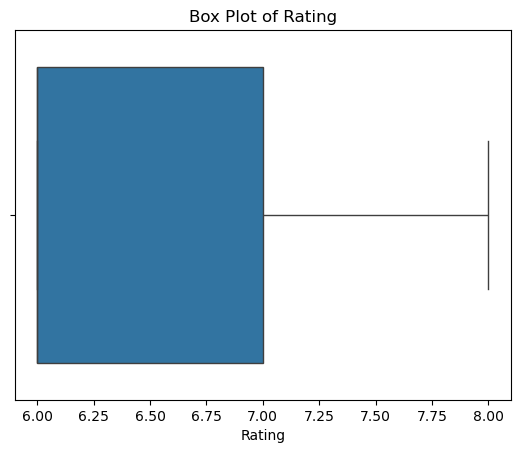

In [24]:
# Box Plot: Visualizes the spread and detects outliers in continuous variables
for col in ['Rating']:
    sns.boxplot(x=df[col])  # Creates a box plot for each continuous variable
    plt.title(f"Box Plot of {col}")  # Title for each plot
    plt.xlabel(col)  # Label for the x-axis
    plt.show()  # Display the plot

Key Insights:
------------
1.Median is around 6.50, indicating that most ratings are centered near this value.
2.The interquartile range (IQR) is between 6.00 and 7.00, showing that most ratings are spread within this range.
3.No outliers are visible, indicating that the data is relatively consistent without extreme ratings.
4.The box is centered between 6.25 and 6.75, indicating most ratings fall in this range.

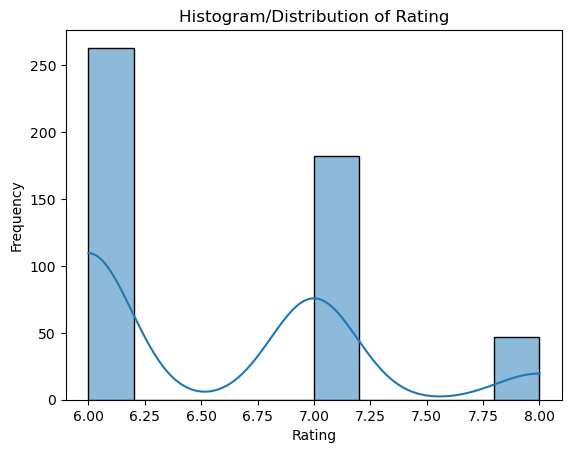

In [25]:
# Histogram/Distribution Plot: Shows the frequency distribution of continuous variables
for col in ['Rating']:
    sns.histplot(df[col], kde=True)  # Creates histogram with KDE for smoother distribution
    plt.title(f"Histogram/Distribution of {col}")  # Title for each plot
    plt.xlabel(col)  # Label for the x-axis
    plt.ylabel("Frequency")  # Label for the y-axis
    plt.show()  # Display the plot


Key Insights:
------------
1.Ratings between 6.00 and 6.25 have the highest frequency (255), indicating a concentration of content with lower ratings.
2.Ratings around 7.00 to 7.25 have a moderate frequency (158), showing a slight drop-off in content ratings.
3.Ratings between 7.75 and 8.00 have the lowest frequency (50), indicating fewer high-rated content.
4.Overall, the distribution is skewed towards lower ratings, with most content clustered around the 6.00 to 6.25 range.

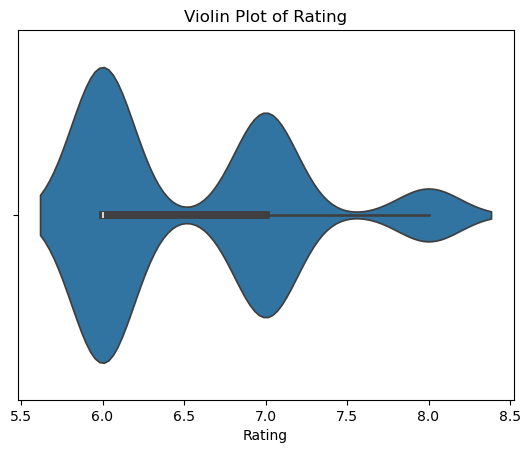

In [26]:
# Violin Plot: Combines aspects of box plot and density plot for distribution analysis
for col in ['Rating']:
    sns.violinplot(x=df[col])  # Creates a violin plot for each continuous variable
    plt.title(f"Violin Plot of {col}")  # Title for each plot
    plt.xlabel(col)  # Label for the x-axis
    plt.show()  # Display the plot

Key Insights:
------------
1.Range: The plot covers ratings from 5.5 to 8.5, showing the full distribution of ratings.
2.Median: The median rating is at 6.0, which indicates the central point of the dataset.
3.Density: The distribution has its highest density between 6.0 and 7.0, meaning most of the ratings fall within this range.
4.Skewness: The plot suggests a slight positive skew, with a tapering of the distribution toward higher ratings, indicating fewer ratings above 7.0.
5.Whiskers: There are no significant outliers, as the whiskers of the violin plot cover the entire rating range without extreme values.

B.Categorical Variables (e.g., Content_Rating)

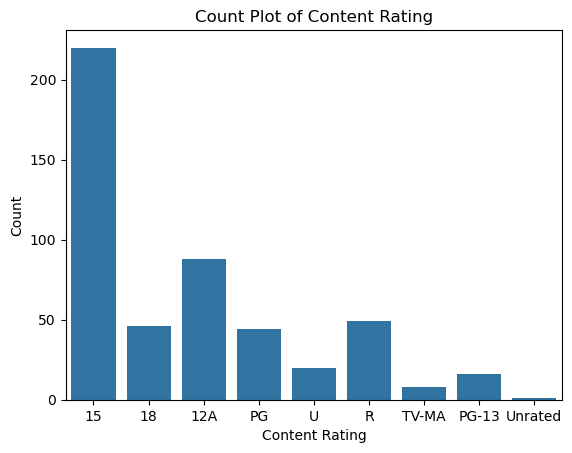

In [21]:
#1. Count Plot: Counts the number of occurrences of each category in Content_Rating
sns.countplot(x='Content_Rating', data=df)  # Creates a count plot for Content_Rating
plt.title("Count Plot of Content Rating")  # Title for the plot
plt.xlabel("Content Rating")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis
plt.show()  # Display the plot

Key Insights:
------------
1.15 has the highest count (255), indicating the majority of the content falls under this rating.
2.18 has a significant count (48), suggesting a fair number of adult-oriented content.
3.12A (98), R (50), and PG (47) have moderate counts, showing a mix of content aimed at both younger and adult audiences.
4.U has a smaller count (10-15), indicating relatively less content rated as suitable for children.
5.TV-MA, PG-13, and Unrated have the smallest counts, with TV-MA (5) being the rarest.

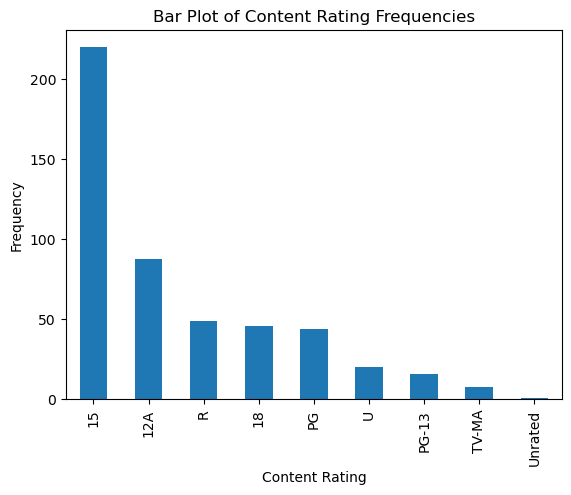

In [12]:
# 2. Bar Plot (Frequency Distribution): Shows the frequency of each category in Content_Rating
title_type_counts = df['Content_Rating'].value_counts()  # Count occurrences of each category
title_type_counts.plot(kind='bar')  # Creates a bar plot for Content_Rating frequencies
plt.title("Bar Plot of Content Rating Frequencies")  # Title for the plot
plt.xlabel("Content Rating")  # Label for the x-axis
plt.ylabel("Frequency")  # Label for the y-axis
plt.show()  # Display the plot


Key Insights:
------------
1.15 has the highest frequency (255), making it the most prevalent content rating in the dataset.
2.18 follows with a moderate frequency (48), indicating a reasonable amount of content is rated for adult audiences.
3.12A (98) and R (50) have moderate frequencies, reflecting a substantial portion of content falls under these ratings.
4.PG (47) and U (15) show lower frequencies, with U having the least content.
5.TV-MA (5), PG-13 (10), and Unrated (1) have the smallest frequencies, suggesting these ratings are quite rare in the dataset.

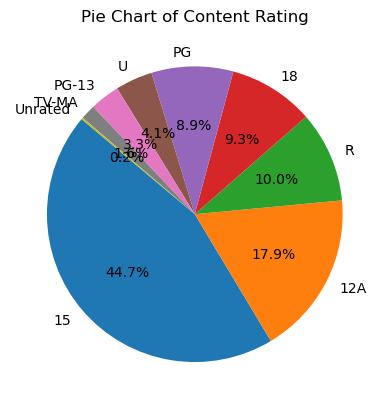

In [13]:
# 3. Pie Chart: Shows the proportion of each category in Content Rating
df['Content_Rating'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)  # Creates a pie chart for Content Rating
plt.title("Pie Chart of Content Rating")  # Title for the plot
plt.ylabel("")  # Remove y-label for a cleaner look
plt.show()  # Display the plot

Key Insights:
------------
1.15 has the largest share (44.7%), indicating it is the most common content rating in the dataset.
2.12A follows with 17.9%, showing a significant portion of content falls under this category.
3.R and 18 categories have moderate shares (10.0% and 9.3% respectively), reflecting a fair amount of content rated for mature audiences.
4.PG and U represent a smaller portion (8.9% and 4.1%), with U being the least frequent.
5.PG-13, TV-MA, and Unrated have the smallest shares (3.3%, 1.6%, and 0.3% respectively), suggesting these are less common in the dataset.

2. Bi-variate/Multivariate Analysis
A. Continuous and Categorical Variables (e.g., Rating and Content Rating)

In [14]:
#1. Groupby Aggregation: Computes the mean Rating for each Content Rating
groupby_result = df.groupby('Content_Rating')['Rating'].mean()  # Group by Content Rating and calculate mean Rating
print(groupby_result)  # Display the aggregation result

Content_Rating
12A        6.636364
15         6.463636
18         6.565217
PG         6.772727
PG-13      6.937500
R          6.408163
TV-MA      6.000000
U          7.150000
Unrated    6.000000
Name: Rating, dtype: float64


Key Insights:
------------
1.U has the highest average rating (7.15), indicating that content rated for all audiences generally receives the highest ratings.
2.PG-13 follows closely with an average rating of 6.94, suggesting favorable reception for this category.
3.PG content has an average rating of 6.77, indicating positive but slightly lower ratings compared to PG-13.
4.12A and 18 have similar ratings (6.64 and 6.57), showing moderate but favorable reviews.
5.R has a slightly lower average rating (6.41), indicating mixed or less favorable reception.
6.TV-MA and Unrated both have the lowest average rating (6.00), suggesting these categories have lower or less consistent ratings.

In [15]:
#2. Pivot Table: Creates a pivot table to calculate the mean and standard deviation of Rating for each Content Rating
pivot_table = df.pivot_table(values='Rating', index='Content_Rating', aggfunc=['mean', 'std'])  
# This calculates both the mean and standard deviation of Rating, grouped by Content Rating
pivot_table  # Display the pivot table result

,mean,std
,Rating,Rating
Content_Rating,,
12A,6.636364,0.714092
15,6.463636,0.551913
18,6.565217,0.688062
PG,6.772727,0.710834
PG-13,6.937500,0.928709
R,6.408163,0.574397
TV-MA,6.000000,0.000000
U,7.150000,0.875094


Key Insights:
------------
1.U has the highest average rating (7.15) with a relatively high standard deviation (0.875), indicating a good but variable reception for family-friendly content.
2.PG-13 follows with an average rating of 6.94, showing slightly better reception than most other categories.
3.12A and 18 have similar ratings around 6.64 and 6.57, with moderate variability.
4.TV-MA has the lowest average rating (6.00) with no variability, indicating consistency in low ratings.
5.R and 15 categories have average ratings around 6.46 and 6.41, reflecting more mixed reviews.
6.Unrated content has an average of 6.00, but due to missing data for standard deviation, it cannot be reliably compared.


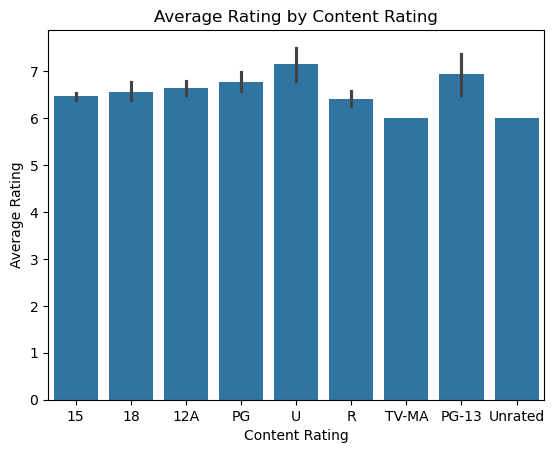

In [16]:
#3. Bar Plot: Shows the average Rating for each Content Rating
sns.barplot(x='Content_Rating', y='Rating', data=df)  # Creates a bar plot for average Rating by Content Rating
plt.title("Average Rating by Content Rating")  # Title for the plot
plt.xlabel("Content Rating")  # Label for the x-axis
plt.ylabel("Average Rating")  # Label for the y-axis
plt.show()  # Display the plot


Key Insights:
------------
1.U: Highest average rating at 7.0, indicating strong positive reception for family-friendly content.
2.PG-13: Close behind at 6.8, reflecting good ratings for content suitable for teens and adults.
3.Other Ratings (R, TV-MA, 18, 12A, 15, PG): All fall between 6.0 and 6.5, suggesting that mature or specialized content has more mixed reception.

B.Continuous to Continuous Variables (e.g., Rating and Vote_Count)

In [17]:
#1. Correlation Matrix: Shows the correlation between continuous variables
correlation_matrix = df[['Rating', 'Vote_Count', 'Duration']].corr()  # Calculate correlation between continuous variables
correlation_matrix  # Display the correlation matrix

,Rating,Vote_Count,Duration
Rating,1.000000,0.061684,0.156104
Vote_Count,0.061684,1.000000,0.176067
Duration,0.156104,0.176067,1.000000


Key Insights:
------------
1.Rating and Vote Count: Very weak positive correlation (0.0617), indicating that the rating and vote count are almost independent of each other.
2.Rating and Duration: Slight positive correlation (0.1561), suggesting a weak connection between movie ratings and their duration.
3.Vote Count and Duration: Weak positive correlation (0.1761), indicating a small relationship between vote count and movie duration.
4.Overall Insight: The correlations are low, implying that the variables (Rating, Vote Count, Duration) do not strongly influence each other in the dataset.

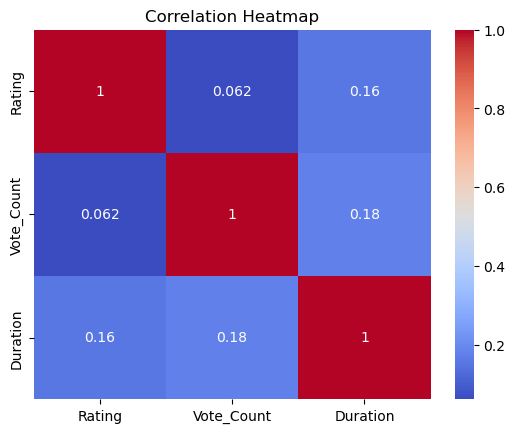

In [18]:
#2. Heatmap: Visualizes the correlation between continuous variables
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Creates a heatmap for the correlation matrix
plt.title("Correlation Heatmap")  # Title for the plot
plt.show()  # Display the plot

Key Insights:
------------
1.Rating and Vote Count: Very weak positive correlation (0.062), indicating minimal relationship between rating and vote count.
2.Rating and Duration: Slight positive correlation (0.16), suggesting a weak connection between movie ratings and their duration.
3.Vote Count and Duration: Weak positive correlation (0.18), showing a small relationship between vote count and movie duration.
4.Overall Insights: There are no strong correlations between the variables, implying that these factors do not heavily influence each other in the dataset.

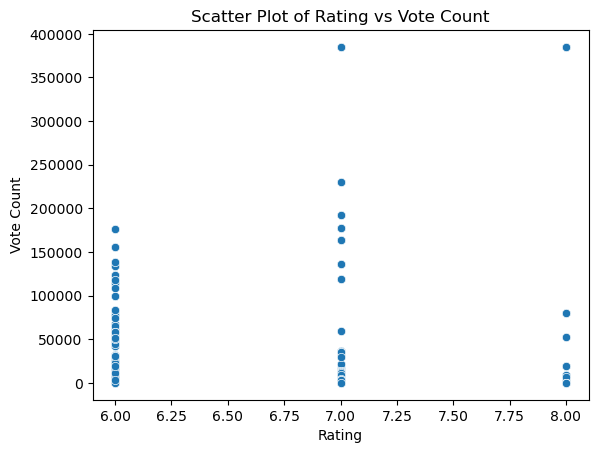

In [19]:
#3. Scatter Plot: Shows the relationship between Rating and Vote_Count
sns.scatterplot(x='Rating', y='Vote_Count', data=df)  # Creates a scatter plot between Rating and Vote_Count
plt.title("Scatter Plot of Rating vs Vote Count")  # Title for the plot
plt.xlabel("Rating")  # Label for the x-axis
plt.ylabel("Vote Count")  # Label for the y-axis
plt.show()  # Display the plot

Key Insights:
------------
1.High concentration at Rating 6: Most movies have a rating around 6, with a high number of votes.
2.Medium concentration at Rating 7: There are moderate vote counts for movies rated 7.
3.Few movies rated 8: Only a few movies have a rating of 8, but these still receive some votes.
4.Rating vs Vote Count: As the rating increases, the number of votes slightly decreases.
5.General trend: Movies with lower ratings (around 6) tend to have higher vote counts.

C. Categorical to Categorical Variables (e.g., Content Rating and Year)

In [20]:
#1. Crosstab: Creates a cross-tabulation (contingency table) of Content Rating vs Year
crosstab_result = pd.crosstab(df['Content_Rating'], df['Year'])  # Cross-tabulate Content Rating and Year
crosstab_result  # Display the crosstab result

Year,2024
Content_Rating,
12A,88
15,220
18,46
PG,44
PG-13,16
R,49
TV-MA,8
U,20
Unrated,1


Key Insights:
------------
1.Most common ratings: 15 is the most frequent, followed by 12A.
2.Moderate adult content: 18 and R ratings are moderately represented.
3.Family-friendly content: PG and U rated movies are less frequent.
4.Limited TV-MA and unrated content: TV-MA and Unrated ratings are rare.
5.Overall trend: Focus on teen and adult content, with less family-friendly and TV-specific content.

Plots we can be drawn based on the data features/columns:
[Box-plot, Bar-plot, count plot, pie chart, scatter-plot, violin-plot,
distribution-plot, heat map, histogram and kde-plot etc., Use all plots for individual variables

In [22]:
def generate_plots(data, column_name):
    """
    Function to generate various plots for a given column.
    It handles numerical and categorical columns differently.
    """
    
    # Set up the plot grid (3x3)
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()
    
    # Box Plot - Shows data spread and outliers
    sns.boxplot(data=data, y=column_name, ax=axes[0])
    axes[0].set_title('Box Plot')
    
    # Bar Plot - For categorical columns, shows frequency of each category
    if data[column_name].dtype == 'object' or data[column_name].nunique() < 20:
        data[column_name].value_counts().plot(kind='bar', ax=axes[1], color='skyblue')
        axes[1].set_title('Bar Plot')
    else:
        axes[1].set_visible(False)
    
    # Count Plot - Counts occurrences of each category in a categorical column
    if data[column_name].dtype == 'object':
        sns.countplot(data=data, x=column_name, ax=axes[2])
        axes[2].set_title('Count Plot')
        axes[2].tick_params(axis='x', rotation=45)
    else:
        axes[2].set_visible(False)
    
    # Pie Chart - Shows the proportion of each category in the column (good for few categories)
    if data[column_name].dtype == 'object' and data[column_name].nunique() < 10:
        data[column_name].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[3])
        axes[3].set_title('Pie Chart')
        axes[3].set_ylabel('')
    else:
        axes[3].set_visible(False)
    
    # Scatter Plot - Shows relationship between two numerical columns (using same column for x and y)
    if data[column_name].dtype != 'object':
        sns.scatterplot(data=data, x=column_name, y=column_name, ax=axes[4])
        axes[4].set_title('Scatter Plot')
    else:
        axes[4].set_visible(False)
    
    # Violin Plot - Shows the distribution of data along with its density
    sns.violinplot(data=data, y=column_name, ax=axes[5])
    axes[5].set_title('Violin Plot')
    
    # Distribution Plot (Histogram + KDE) - Shows data distribution
    sns.histplot(data=data, x=column_name, kde=True, ax=axes[6])
    axes[6].set_title('Distribution Plot')
    
    # Heat Map - Shows correlation between numerical columns (if there are multiple numeric columns)
    if data[column_name].dtype != 'object':
        numeric_data = data.select_dtypes(include=['number'])
        if numeric_data.shape[1] > 1:
            corr = numeric_data.corr()
            sns.heatmap(corr, annot=True, ax=axes[7])
            axes[7].set_title('Heat Map')
        else:
            axes[7].set_visible(False)
    else:
        axes[7].set_visible(False)
    
    # Remove extra axes if not used
    for i in range(8, len(axes)):
        axes[i].set_visible(False)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()


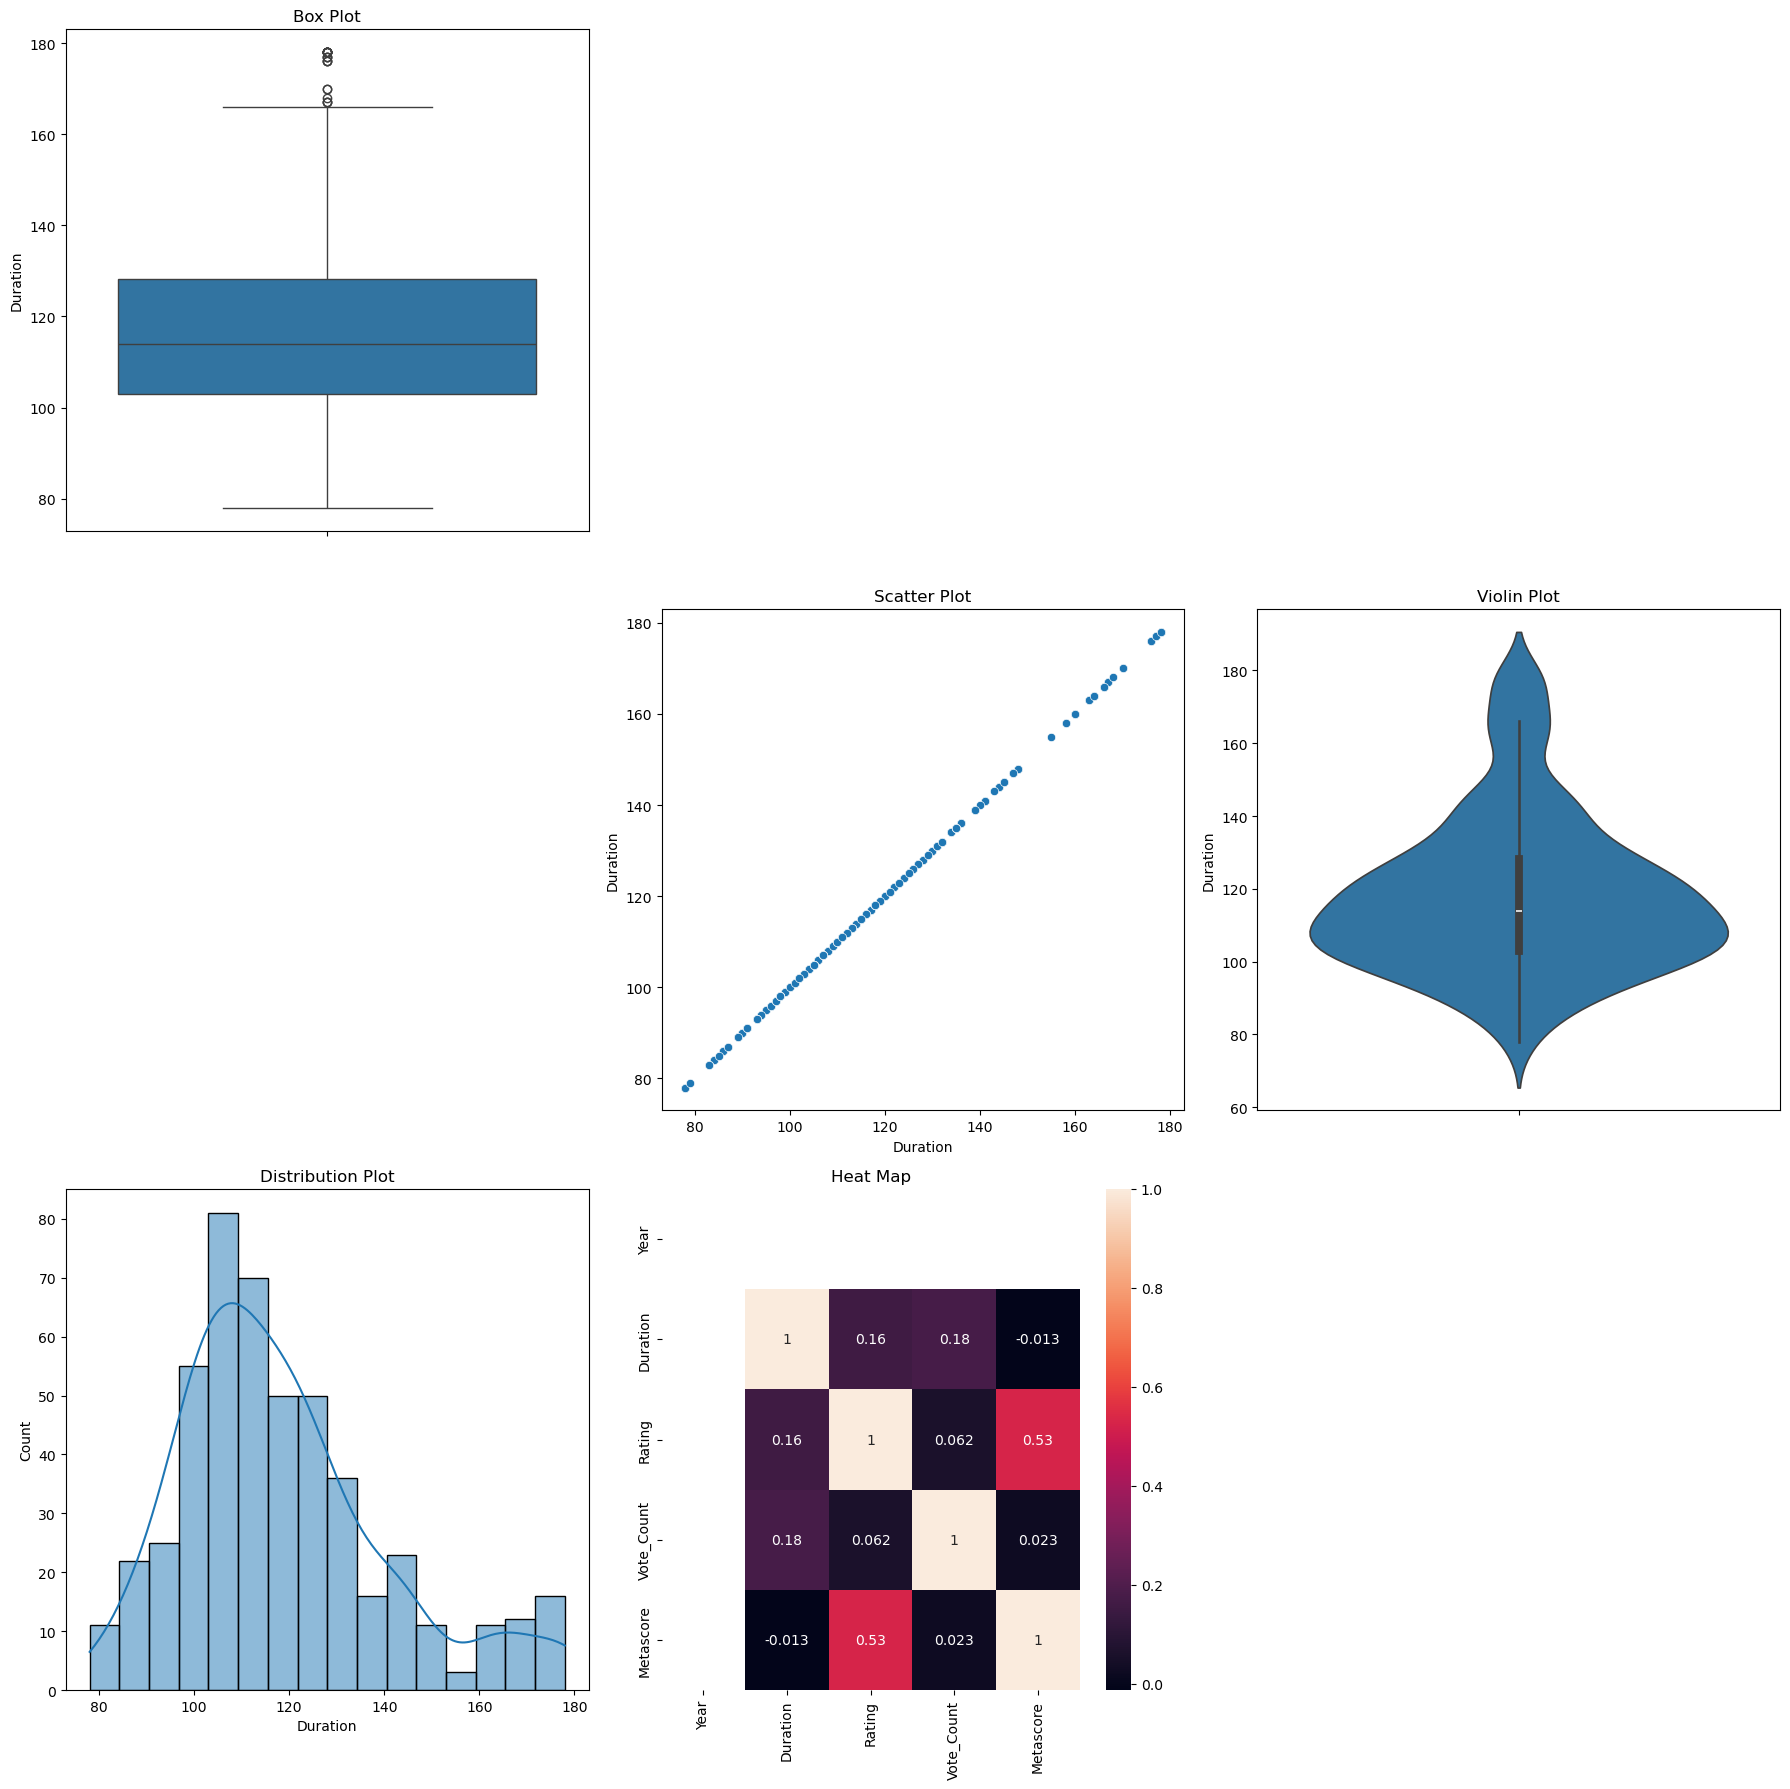

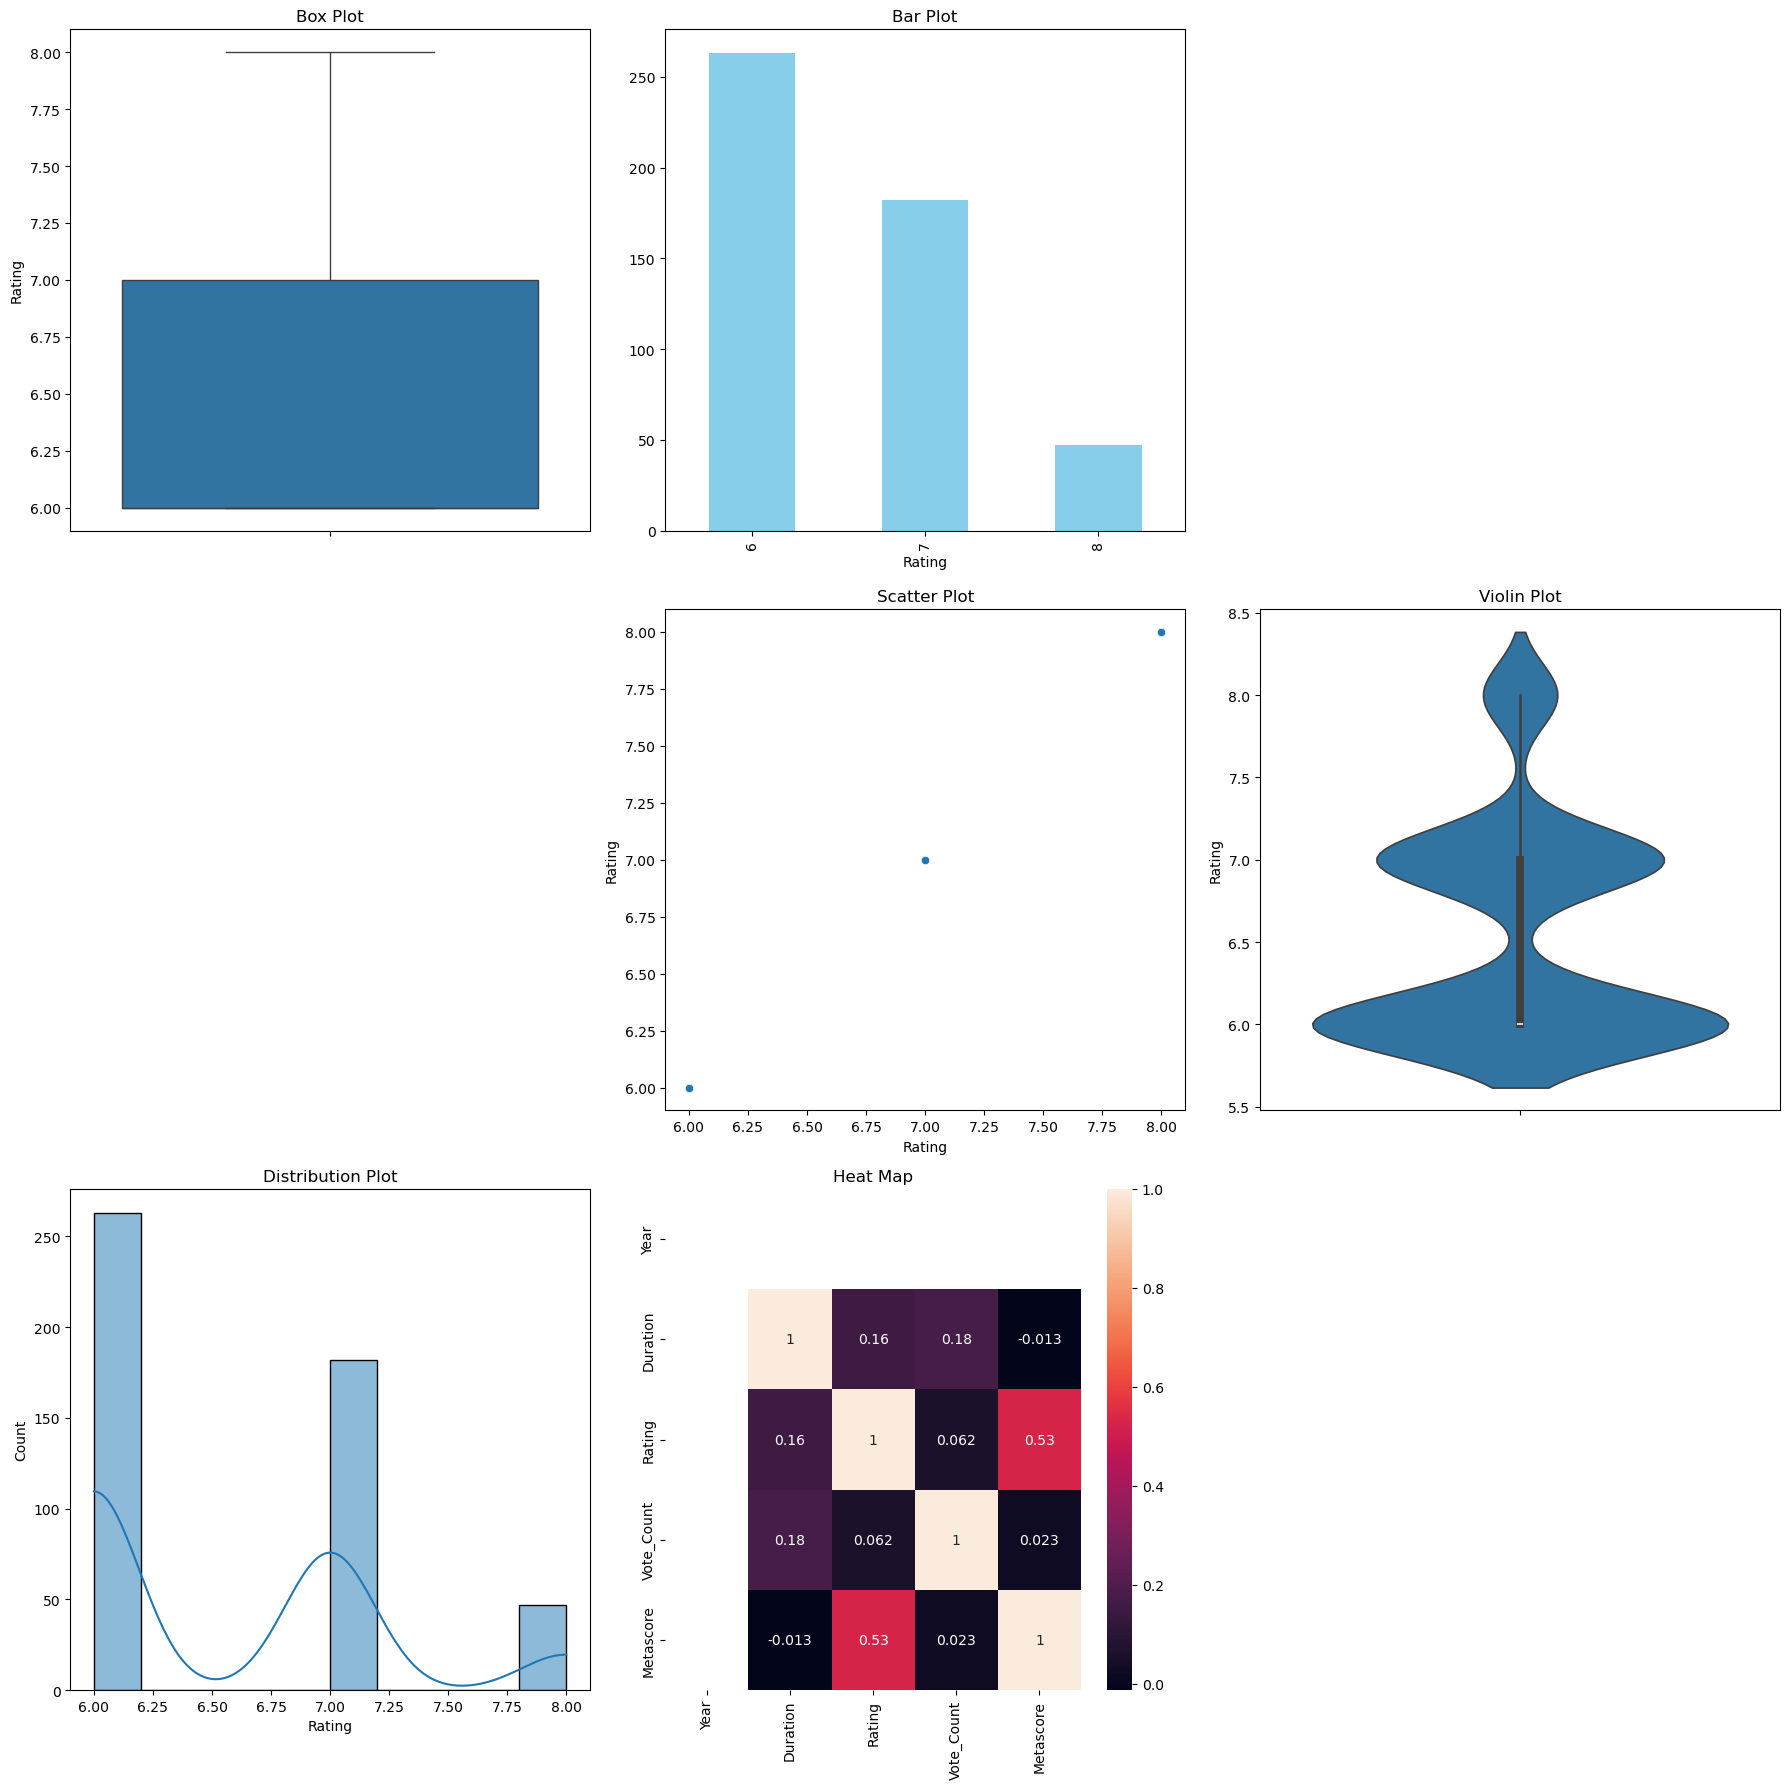

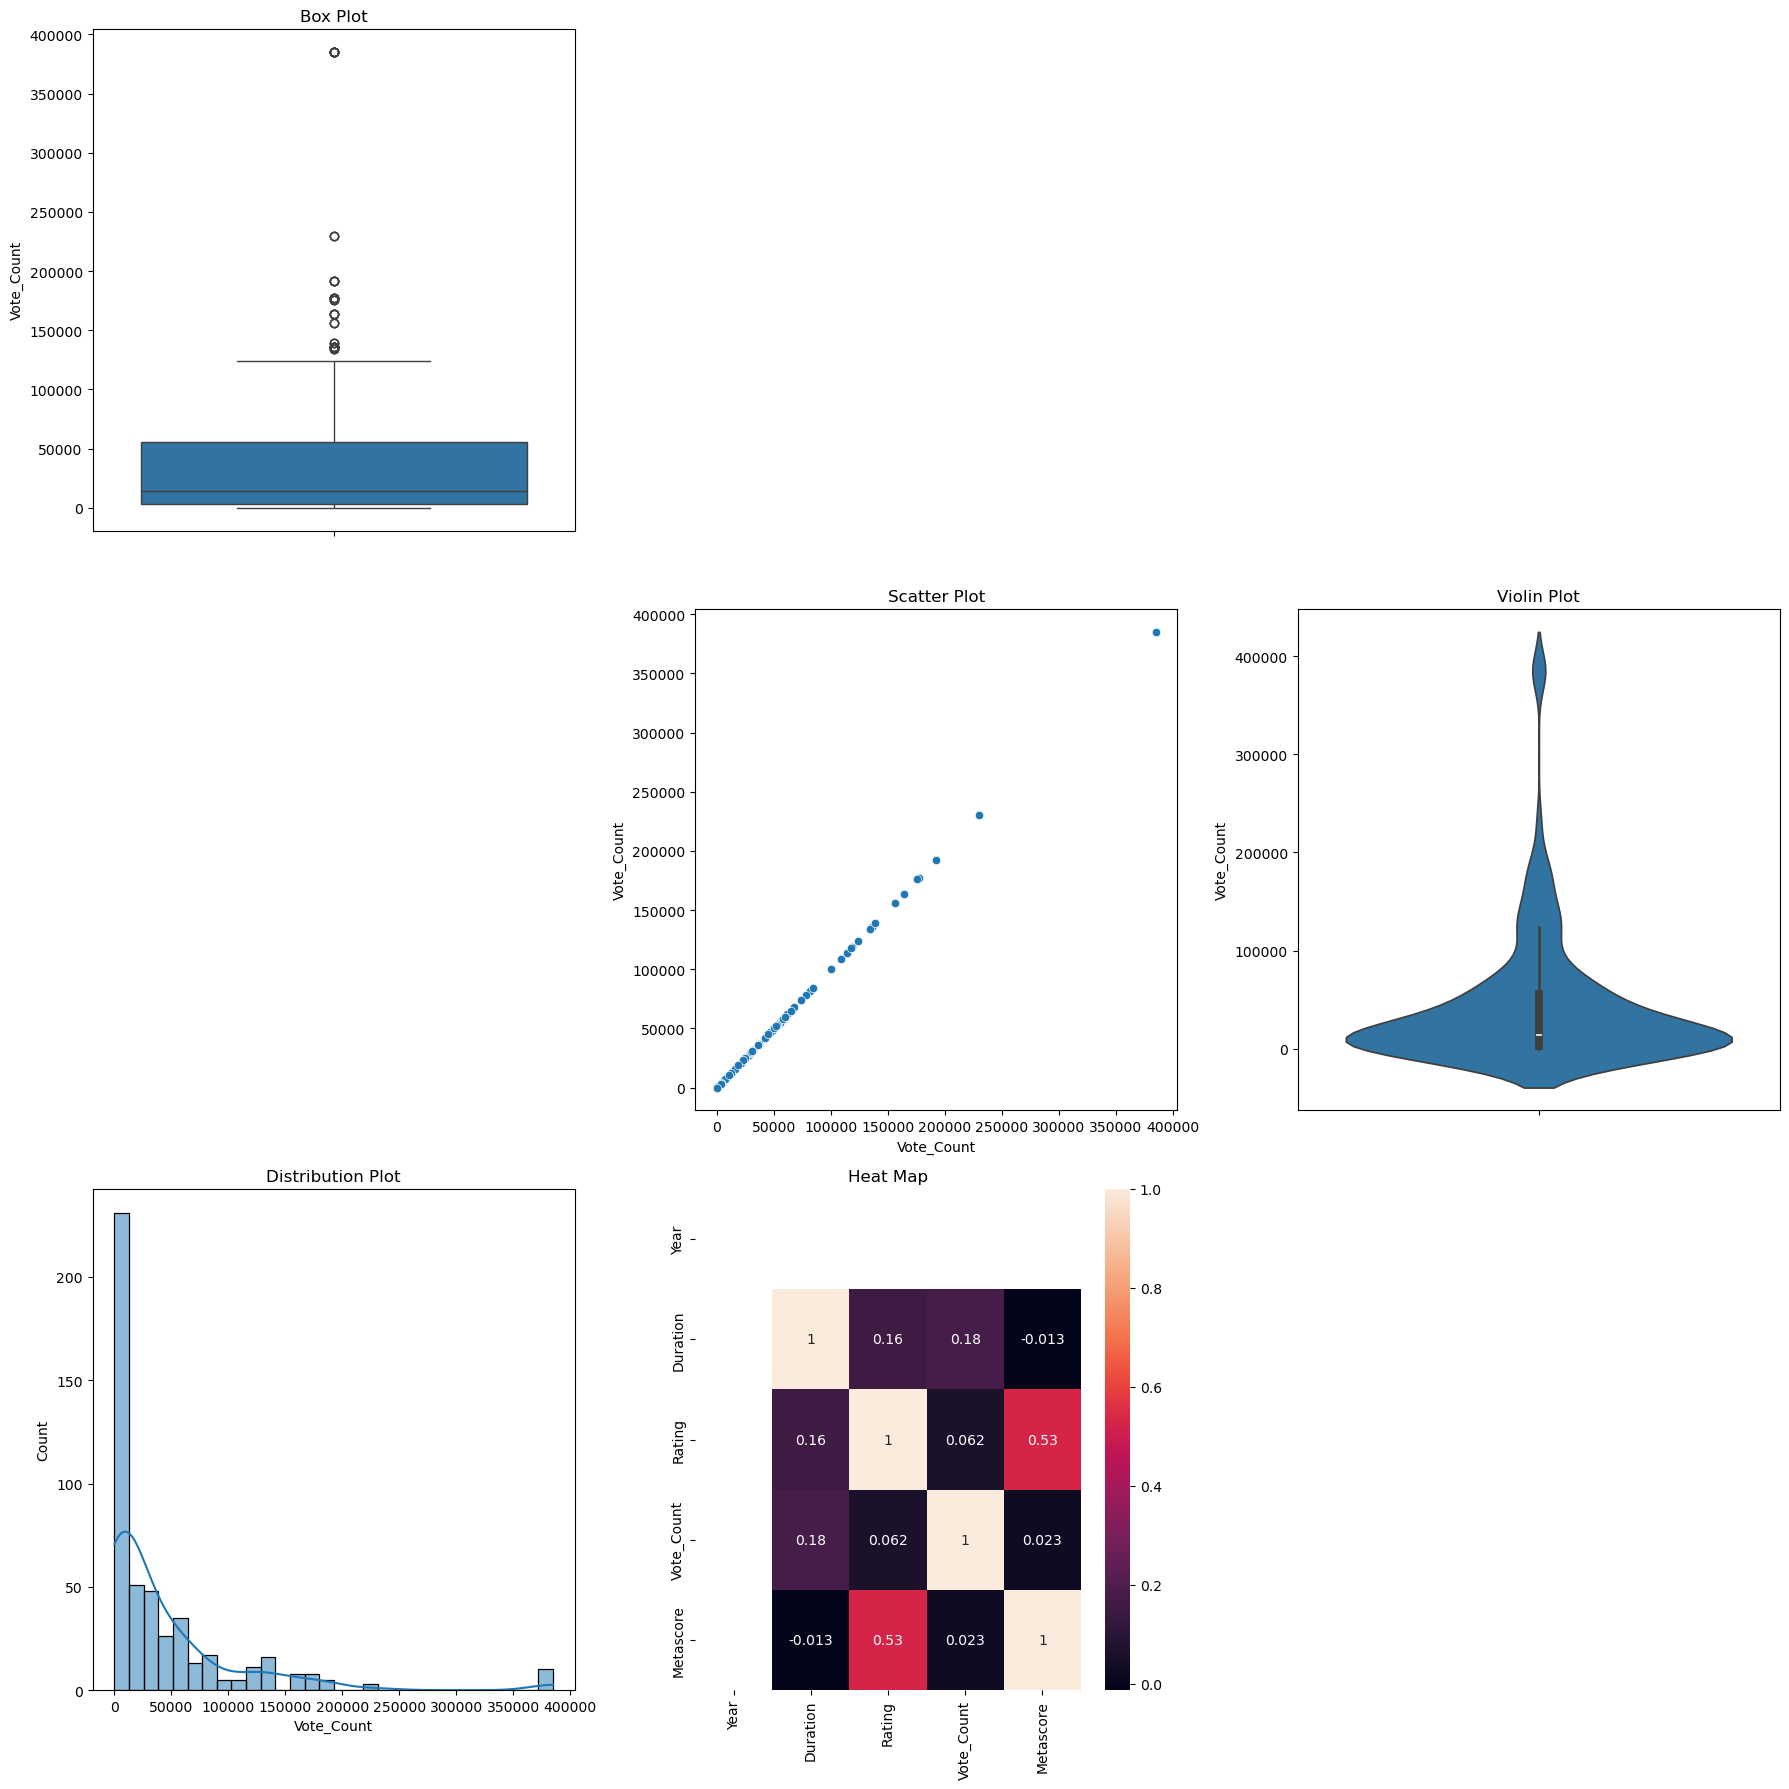

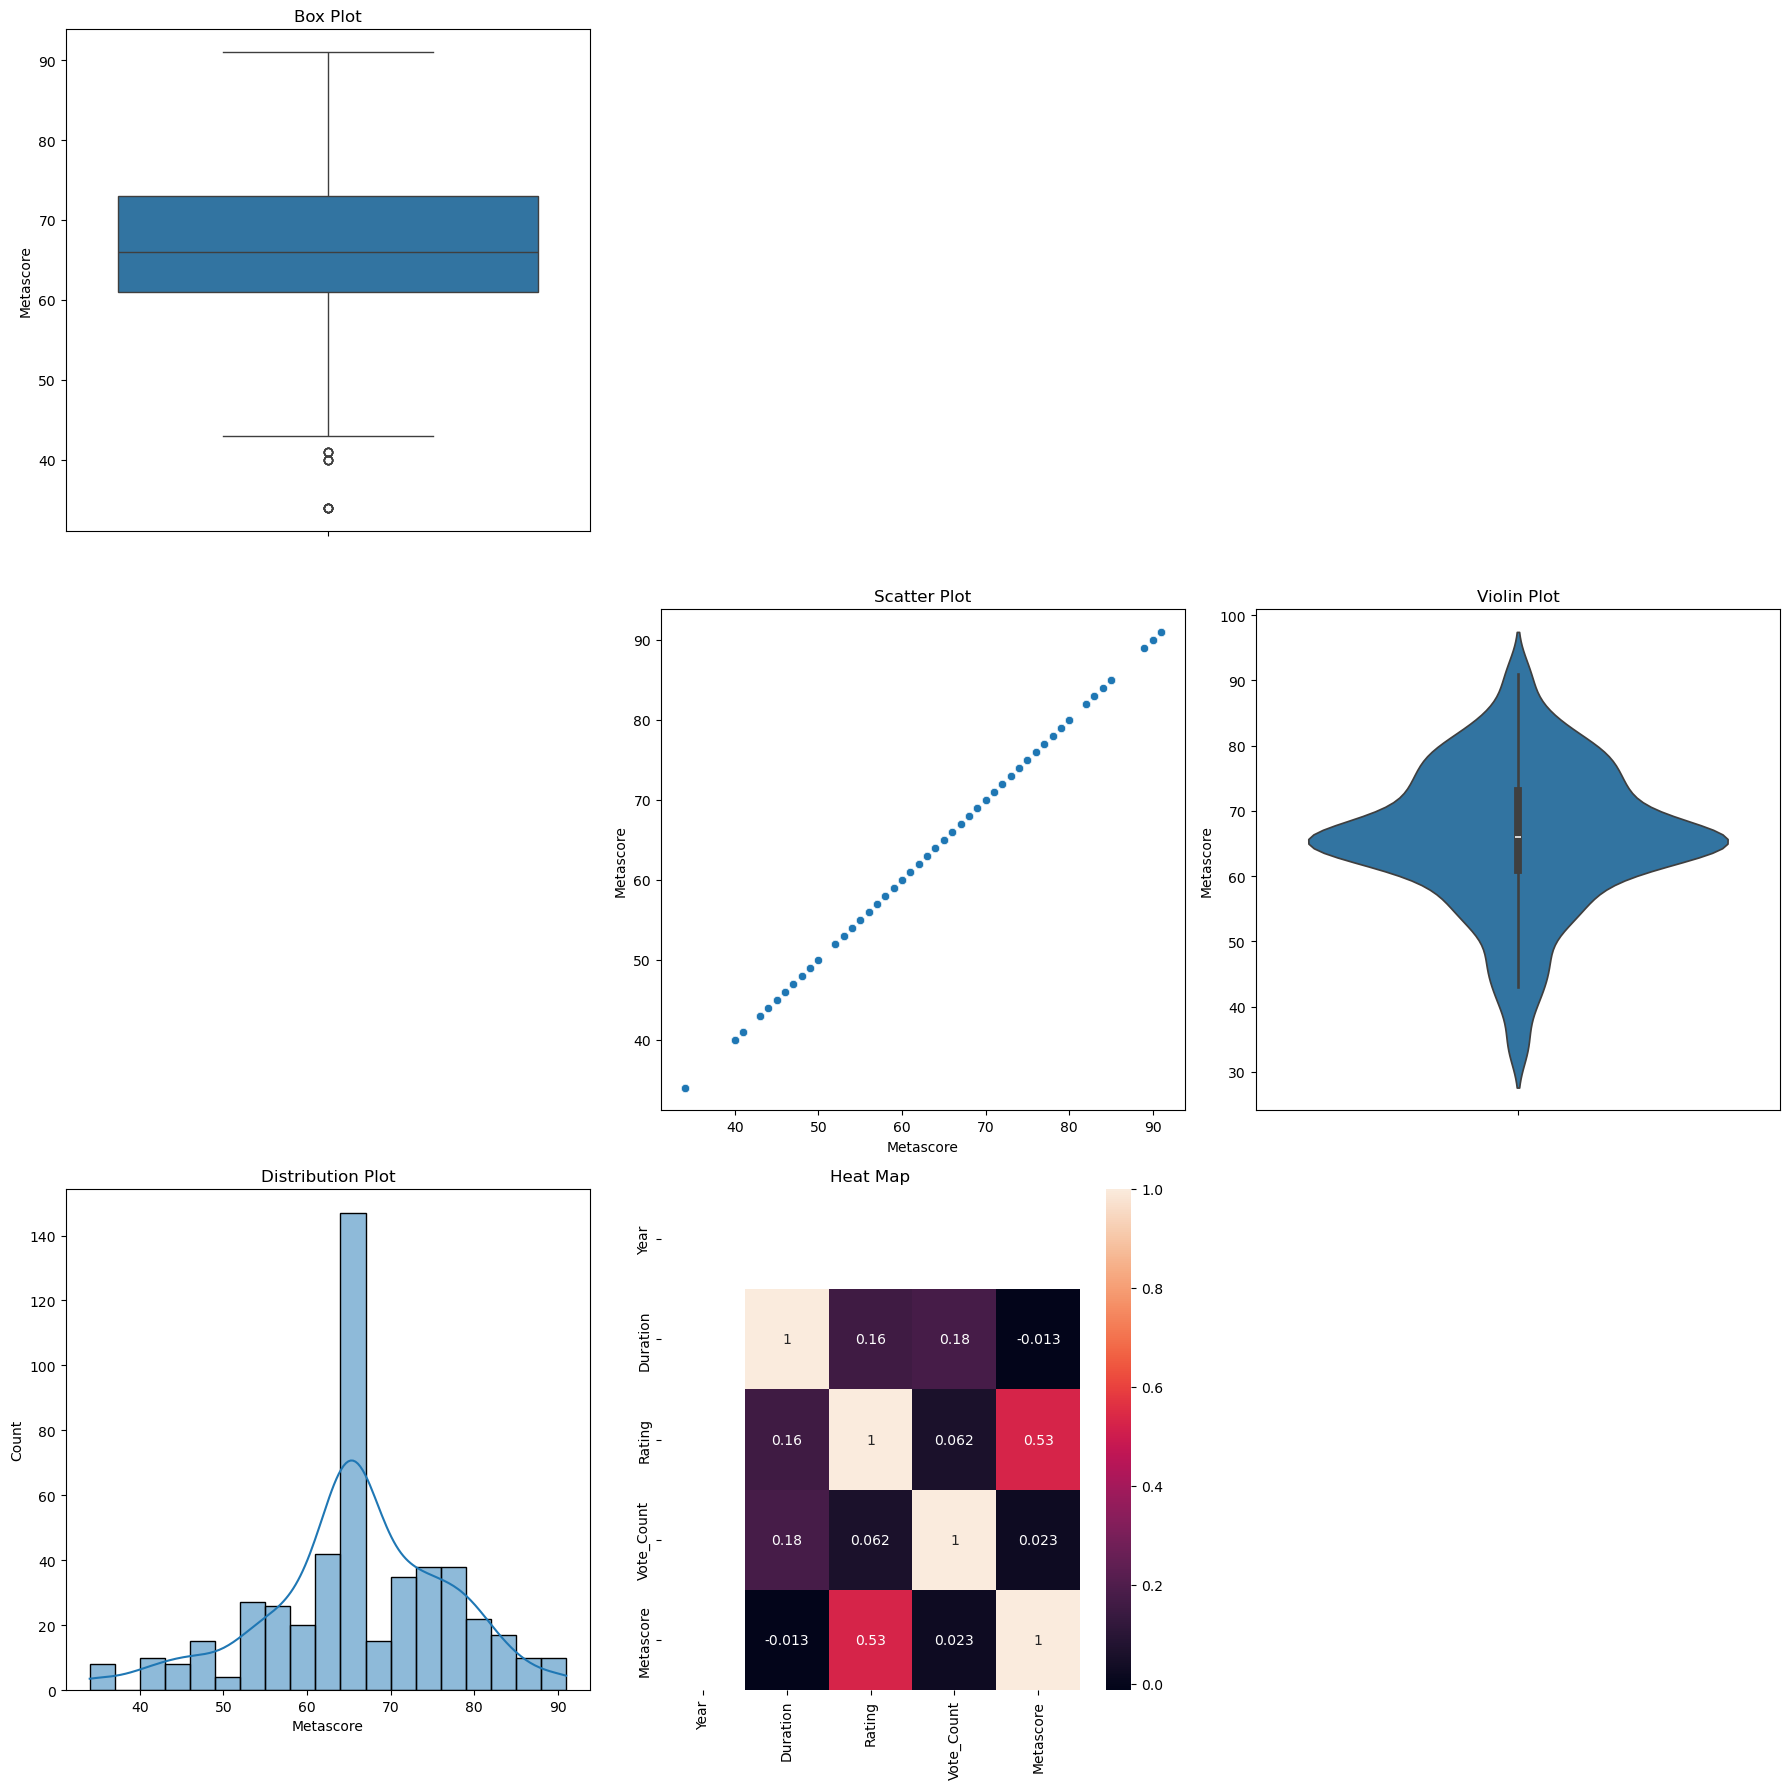

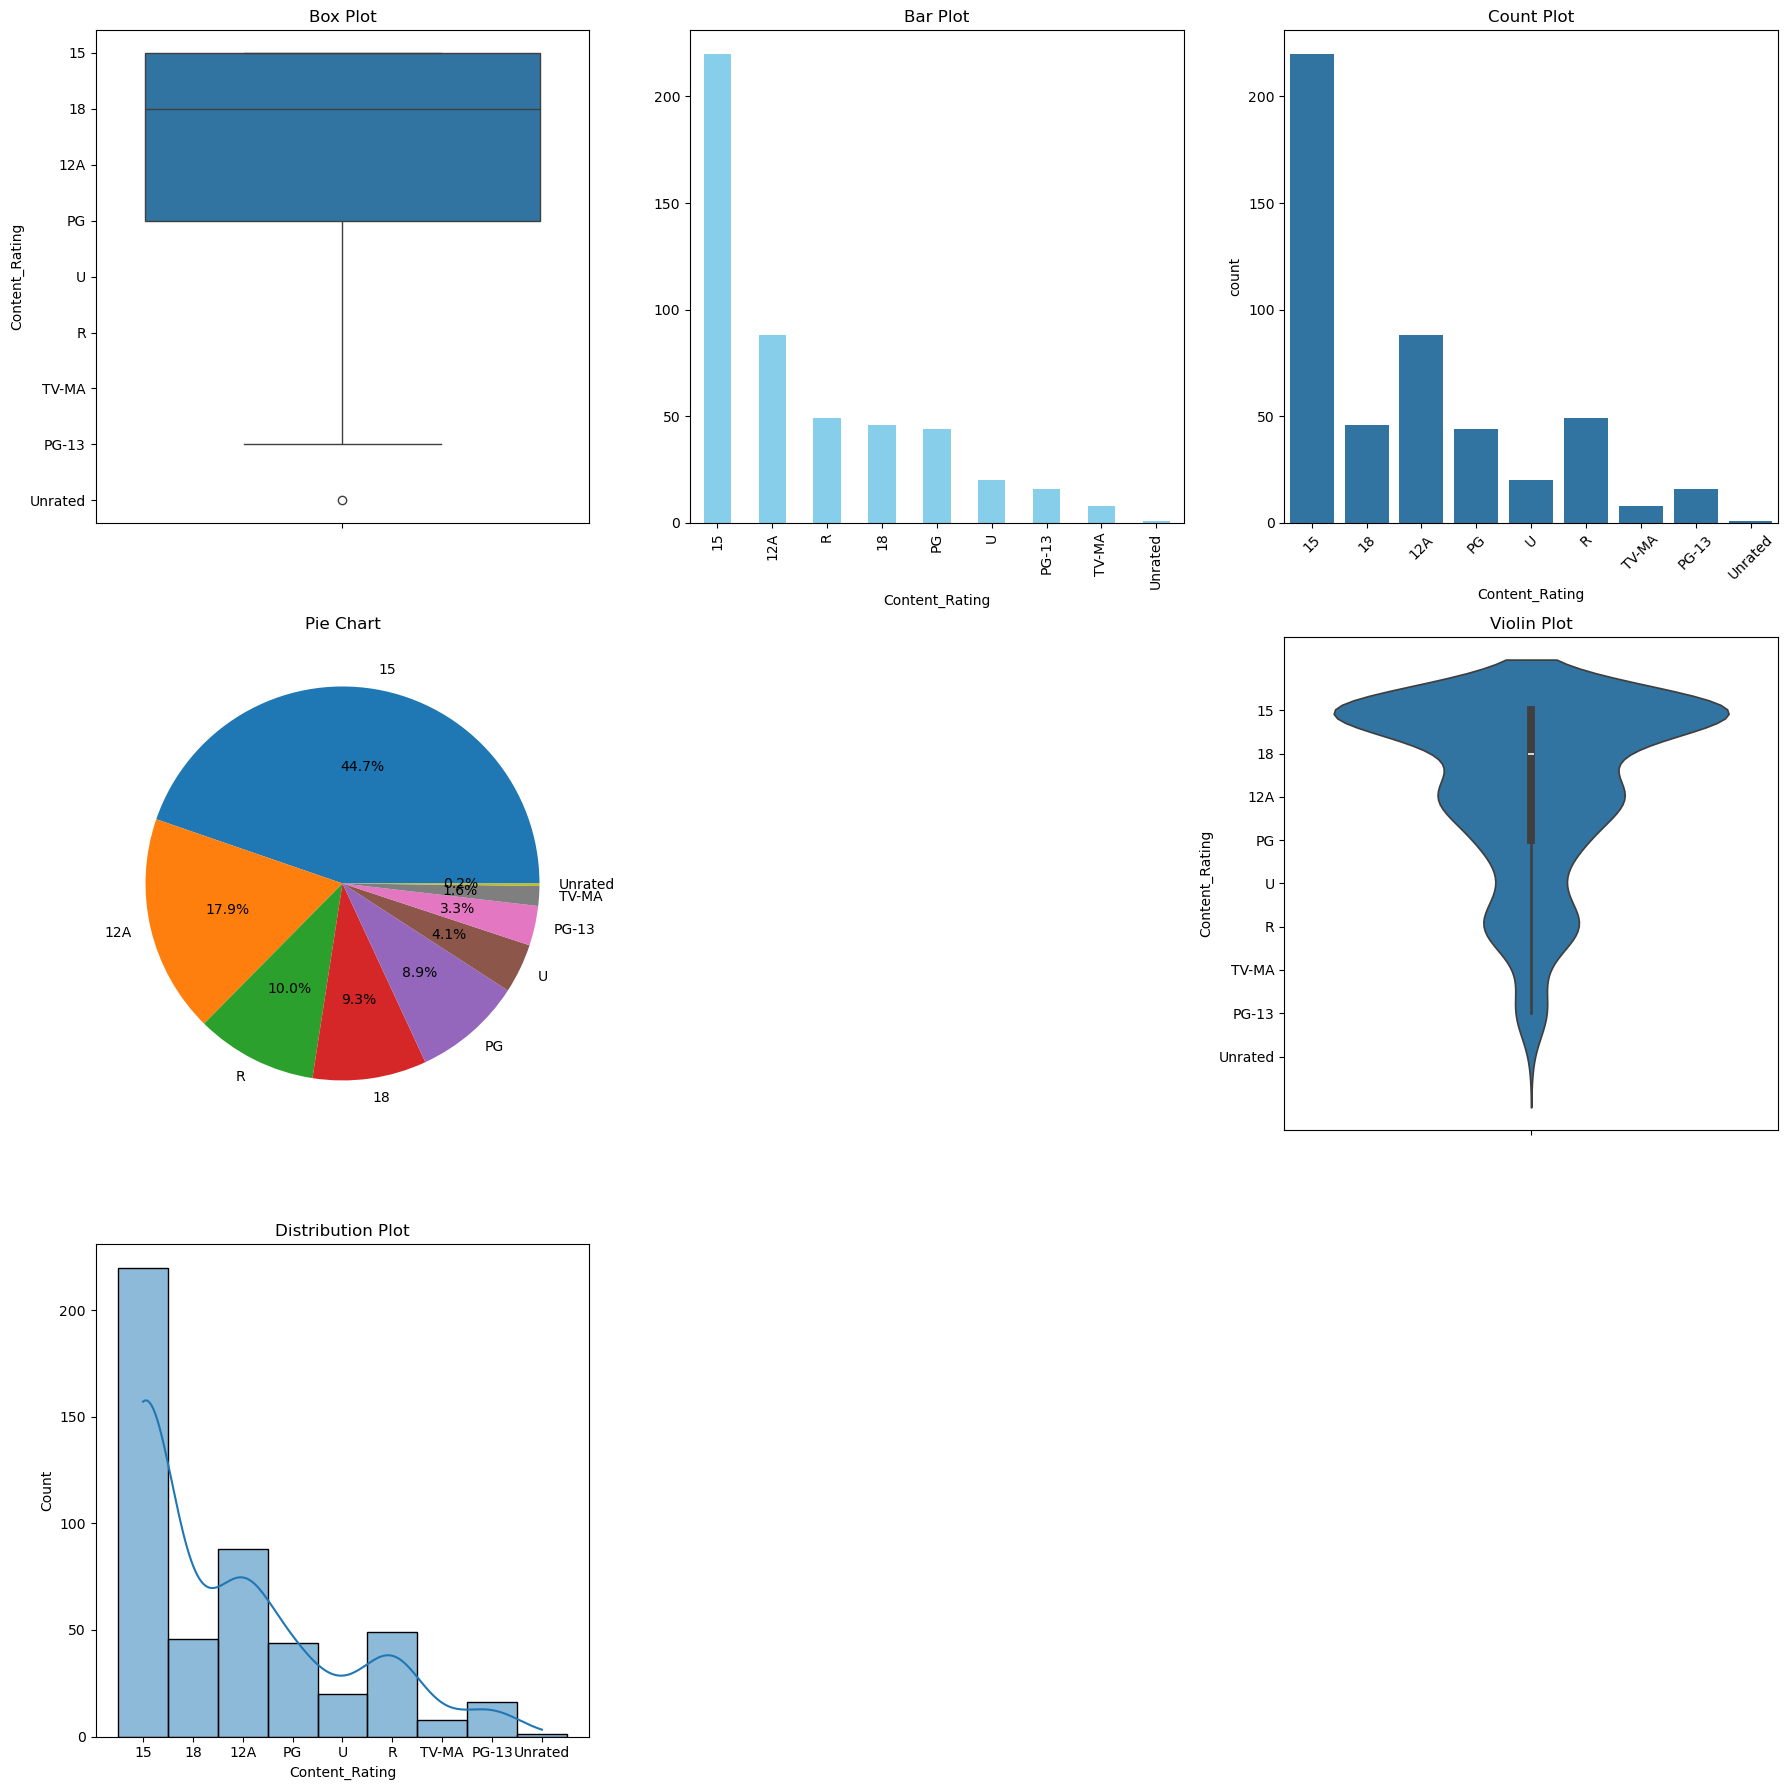

In [23]:
columns_to_plot = ['Duration', 'Rating', 'Vote_Count', 'Metascore', 'Content_Rating']

for column in columns_to_plot:
    generate_plots(df, column)


Conclusion:
----------
Content Ratings and Appeal:
--------------------------
Movies rated 15 and 12A dominate in production, indicating their broad audience appeal.
U-rated movies lead in average ratings (7.15), followed by PG-13 and PG, highlighting their popularity with family-friendly audiences.

Popularity and Votes:
--------------------
15-rated movies receive the highest vote counts, reflecting their widespread reach.
A weak correlation (0.0617) between ratings and votes suggests minimal influence of ratings on audience engagement.

Trends Over Time:
----------------
In 2024, 15-rated movies dominated production, but U-rated content consistently delivered the best ratings.
Family-friendly movies like U and PG maintain strong audience approval across all metrics.

Insights for Strategy:
---------------------
U and PG-13 movies are prime candidates for strategic focus due to high ratings and engagement.
Slight preference for longer movies (correlation = 0.1561) suggests storytelling depth may attract better ratings.

Summary:
-------
Family-friendly and broad-appeal movies, particularly those rated U and PG-13, perform consistently well. These insights can guide production and marketing strategies to target high-performing content while catering to diverse audience preferences.